[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RikVoorhaar/probastat2020/blob/master/notebooks/programmation3.ipynb?hl=fr)

# Série de programmation 3

In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import datetime

## Partie 1: Inférence bayésienne

Dans ce partie on analysera la question suivante

> On a fait un sondage non-biaisé de 200 personnes pour estimer l'opinion d'une population. Nous avons reçu 95 réponses positives et 105 réponses négatives. Quelle est la probabilité que l'opinion de la population est plus souvent négative ou positive?

Soit $Q$ la variable aléatoire à valeurs $[0,1]$ qui décrit la proportion de population avec une opinion positive. Soit $N_1$, $N_2$  le nombre de personnes qui ont données une opinion négative respectivement positive au sondage. On peut modeler $P(N_1=n_1 | Q=q)$ comme une loi binomiale avec $N=N_1+N_2$ répetitions et probabilité $q$ de succès. On définit la vraisemblance $L(q)$ de $Q$ par 

$$
    L(q) = P(N_1=n_1 | Q=q)=\binom{N}{n_1}q^{n_1}(1-q)^{N-n_1}
$$

c'est-à-dire, la vraisemblance de paramètre $q$ est donnée par la probabilité d'observer nos données sachant que $q$ prend une valeur particulière. 

On veut utiliser $L(q)$ pour modeler une densité de probabilité pour $Q$. Notons que $L(q)$ n'est pas une densité de probabilité parce que $\int_0^1\!L(q)\,\mathrm dq\neq 1$, mais si cette intégrale est finie on peut normaliser $L(q)$ pour qu'elle soit une densité de probabilité. C'est-à-dire, définissons :

$$
    f_Q(q) = L(q) \left(\int^0_1\!L(q)\,\mathrm dq\right)^{-1}
$$

et nous modélisons

$$
P(Q\leq q) = \int_{0}^q\! f_Q(x)\,\mathrm dx
$$

_____
> __Exercice 1a)__  
> Écrire une fonction `vraisemblance(q,N1,N)` qui donne une liste / array des vraisemblances $L(q)$ sachant que `N1` personnes ont données une réponse positive dans le sondage parmi `N` personnes. Ici le paramètre `q` est une array, et `N1` et `N` sont scalaires.
>
> _Suggestion:_ Utiliser `scipy.stats.binom.pmf(k, n, p)` pour calculer la densité de loi binomiale. Alternativement, utiliser `scipy.special.binom(n, k)` pour calculer des coefficients binomiaux. Notons que ces fonctions marchent aussi si ses arguments sont des arrays.  

_____

In [2]:
def vraisemblance(q,N1,N):
    # BEGIN SOLUTION
    return scipy.stats.binom.pmf(N1,N,q)
    # END SOLUTION

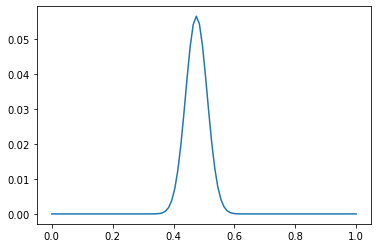

In [3]:
q = np.linspace(0,1,100)
plt.plot(q,vraisemblance(q,95,200));

In [4]:
# TESTS AUTOMATIQUES

x = vraisemblance(np.linspace(0,1,10),10,20)
assert len(x) == 10, "La resultat doit être la même taille que la paramètre `q`"
assert x[0]==0, "La vraisemblence de q=0 doit être 0 si N1!=0"
assert abs(np.sum(x)-0.4285)<0.01, "Verifier la resultat"
x = vraisemblance(np.linspace(0,1,5),0,10)
assert len(x) == 5, "La resultat doit être la même taille que la paramètre `q`"
assert x[0]==1, "Si N1=0, la vraisemblence de q=0 doit être 1"
assert x[-1]==0, "Si N1=0, la vraisemblence de q=1 doit être 0"
assert abs(np.sum(x)-1.05729)<0.01, "Verifier la resultat" 

_____
> __Exercice 1b)__  
> Écrire une fonction `probabilite_positive(N1,N)` qui estime la probabilité $P(Q>0.5)$ que le paramètre $q$ est plus grand que $0.5$ sachant `N1` réponses positives parmi `N` réponses en totale.
> 
> _Indications:_  
>
> - Calculer la vraisemblance $L(q)$ pour 1000 valeurs de $q$ entre 0 et 1.  
> - Normaliser l'array des vraisemblances en divisant par la somme de l'array.  
> - Calculer la somme des éléments qui correspond à $q>0.5$.  

_____

In [5]:
def probabilite_positive(N1,N):
    # BEGIN SOLUTION
    q = np.linspace(0,1,1000)
    L = vraisemblance(q,N1,N)
    L /= np.sum(L)
    return np.sum(L[q>0.5])
    # END SOLUTION

print(f'Probabilité que Q>0.5: {probabilite_positive(95,200):.4f}')

Probabilité que Q>0.5: 0.2403


In [6]:
# TESTS AUTOMATIQUES

p = probabilite_positive(95,200)
assert isinstance(p,float), "Le resultat n'est pas un nombre"
assert (p>=0) and (p<=1), "Le resultat doit être une probabilité"
assert abs(p-0.2403) < 0.01, "La resultat n'est pas correcte"
if abs(p-0.7597) < 0.01:
    raise AssertionError("Vous avez calculé P(Q<0.5) et pas P(Q>0.5)")
p = probabilite_positive(0,100)
assert (p>=0) and (p<=1), "Le resultat doit être une probabilité"
assert p < 1e-14, "Si N1=0 la probabilité P(Q>0.5) doit être très petit"
p = probabilite_positive(10,20)
assert abs(p-0.5)<1e-5, "Si N1 = N/2 on a que P(Q>0.5) = 0.5"

De la même manière on peut calculer la probabilité $P(Q>0.5)$ avec la théorème de Bayes. On a que :

$$
    P(Q\leq q | N_1=n_1,N_2=n_2) = \frac{P(N_1=n_1,N_2=n_2|Q\leq q)P(Q\leq q)}{P(N_1=n_1,N_2=n_2)}
$$


Tous les termes dans cette expression ont des noms:

- $P(Q\leq q | N_1=n_1,N_2=n_2)$ est la probabilité postérieure
- $P(N_1=n_1,N_2=n_2|Q\leq q)$ est la vraisemblance
- $P(Q\leq q)$ est la probabilité a priori
- $P(N_1=n_1,N_2=n_2)$ est la probabilité a priori des données

Dans l'inférence bayésienne la probabilité a priori joue un rôle important. Il encode tous les information préalable. Pour les variables comme $Q$ qui représentent une probabilité ou proportion, on utile souvent la probabilité a priori suivante de la loi bêta $\mathrm{Beta}(\alpha,\beta)$. Cette loi a une densité de probabilité de forme

$$
    f(x) = \frac{1}{B(\alpha,\beta)}x^{\alpha-1}(1-x)^{\beta-1}
$$

ou $B(\alpha,\beta)$ est la fonction bêta qui est defini par $B(\alpha,\beta)=\int_0^1\!x^{\alpha-1}(1-x)^{\beta-1}\,\mathrm dx$. 

Avec un calcul assez facile on peut montrer que avec cette probabilité a priori, la probabilité postérieure suit aussi la loi bêta $B(\alpha+n_1,\beta+n_2)$. Donc on a que 

$$
    P(Q\leq q| N_1=n_1,N_2=n_2)) = \int_0^q\!\frac{1}{B(\alpha+n_1,\beta+n_2)}x^{\alpha+n_1-1}(1-x)^{\beta+n_2-1}\,\mathrm dx
$$

Si on n'a pas d'informations préalable, on peut choisir $\alpha,\beta =1$ qui correspond à une probabilité a priori uniforme. 

_____
> __Exercice 1c)__  
> Écrire une fonction `probabilite_posterieure(q,alpha,beta,N1,N2)` qui estime la probabilité postérieure $P(Q>0.5|N_1=n_1,N_2=n_2)$ sachant la probabilité a priori de $Q$ de loi bêta $B(\alpha,\beta)$.
> 
> _Suggestion:_ Utiliser `scipy.stats.beta.cdf(q, alpha, beta)` pour calculer la fonction de répartition de la loi bêta.
>
> _Remarque: On trouve la même probabilité qu'avant. Si on choisi `alpha` et `beta` différente de 1, la probabilité va changer_  

_____

In [7]:
def probabilite_posterieure(q,alpha,beta,N1,N2):
    # BEGIN SOLUTION
    return 1-scipy.stats.beta.cdf(q,alpha+N1,beta+N2)
    # END SOLUTION

print(f'Probabilité que Q>0.5: {probabilite_posterieure(0.5, 1, 1, 95, 105):.4f}')

Probabilité que Q>0.5: 0.2403


In [8]:
# TESTS AUTOMATIQUES

p = probabilite_posterieure(0.5, 1, 1, 95, 105)
assert isinstance(p,float), "Le resultat n'est pas un nombre"
assert (p>=0) and (p<=1), "Le resultat doit être une probabilité"
assert abs(p-0.2403) < 0.001, "La resultat n'est pas correcte si alpha=1, beta=1"
if abs(p-0.7597) < 0.001:
    raise AssertionError("Vous avez calculé P(Q<0.5) et pas P(Q>0.5)")
p = probabilite_posterieure(0.5, 0, 0, 95, 105)
assert (p>=0) and (p<=1), "Le resultat doit être une probabilité"
assert abs(p-0.23924) < 0.001, "La resultat n'est pas correcte si alpha=0, beta=0"
p = probabilite_posterieure(0.5, 20, 10, 95, 105)
if abs(p-0.09308)<0.001:
    raise AssertionError("Vous avez interchance les rôles de alpha et beta")
assert abs(p-0.5) < 1e-6, "La resultat n'est pas correcte si alpha=20, beta=10"
p = probabilite_posterieure(0.5, 0, 0, 10, 20)
assert abs(p-0.03071) < 0.001, "Vérifier la resultat"
p = probabilite_posterieure(0,1,1,10,10)
assert abs(p-1) < 1e-6, "La probabilité P(Q>0) doit être 1"
p = probabilite_posterieure(1,1,1,10,10)
assert abs(p) < 1e-6, "La probabilité P(Q>1) doit être 0"

## Partie 2: Sondages d'élection présidentielle américaine de 2020

Dans la partie précédente nous avons analysé un sondage non-biaisé, mais en réalité c'est presque impossible d'avoir un sondage non-biaisé. Dans cette partie on va analyser des sondages d'élection présidentielle américaine de 2020. On va voir que des sondages différents ont des résultats différents. Si nous avons beaucoup de sondages différens on peut utiliser la variance entre les sondages différents comme indicateur de incertitude. D'abbord on va télécharger un tableau des resultats de beaucoup de sondages, agrégé par [FiveThirtyEight](https://data.fivethirtyeight.com/) et modifiés en supprimant des données sans intérêt.

Ces données ont 5 colonnes:

- `state`: Le nom d'état
- `sample_size`: La taille de l'échantillon du sondage
- `answer`: `Biden` ou `Trump`
- `pct`: Le pourcentage des réponses avec réponse `answer` dans ce sondage.
- `votes`: Le nombre des votes du collège électoral de cet état

Remarques:

- La somme des pourcentages `pct` ne doit pas être égal à 100. (en raison des candidats de tiers qui sont supprimé)
- Le candidat qui gagne une majorité dans un état gagne tous les votes du collège électoral de cet état.
- En cas d'états Maine/Nebraska le vainqueur de la majorité gagne 2, respectivement 3 votes. De plus ces des états contiennent des districts (2 chacun),  et chaque victoire dans un district apporte un vote supplémentaire. À cause de ça, les deux districts de Maine et Nebraska sont mentionnés séparément.

_Évaluer la cellule ci-dessous pour télécharger les données._

In [9]:
import urllib.request
from urllib.error import URLError
import os.path
if not os.path.isfile('president_polls_parsed.csv') :
    url = r"https://raw.githubusercontent.com/RikVoorhaar/probastat2020/master/notebooks/president_polls_parsed.csv"
    try:
        with urllib.request.urlopen(url) as request:
            data = request.read().decode('utf-8')
            with open('president_polls_parsed.csv','w',encoding='utf-8') as f:
                f.write(data)
    except URLError:
        print('Erreur de téléchargement! Télécharger manuellement:\n'+url)
polls = pd.read_csv('president_polls_parsed.csv')
polls

,state,sample_size,answer,pct,votes
0,Iowa,871.0,Biden,49.0,6
1,Iowa,871.0,Trump,48.0,6
2,Pennsylvania,499.0,Biden,48.4,20
3,Pennsylvania,499.0,Trump,49.2,20
4,Florida,400.0,Biden,47.0,29
...,...,...,...,...,...
7215,Arizona,600.0,Trump,44.0,11
7216,Maine,1022.0,Biden,53.0,2
7217,Maine,1022.0,Trump,42.0,2
7218,Georgia,513.0,Biden,45.0,16


Pour manipuler des données en Python on utilise `pandas`. L'objet principal dans `pandas` est le `DataFrame`. On peut facilement accéder des lignes et colonnes d'un `DataFrame`. Par example, si on veut tous les données ou la colonne `state` est égal à `'Texas'` on écrit simplement:

In [10]:
texas = polls[polls.state == 'Texas']
texas

,state,sample_size,answer,pct,votes
30,Texas,1151.0,Biden,47.20,38
31,Texas,1151.0,Trump,51.20,38
120,Texas,926.0,Biden,49.00,38
121,Texas,926.0,Trump,48.00,38
228,Texas,8250.0,Biden,50.00,38
...,...,...,...,...,...
7103,Texas,750.0,Trump,49.45,38
7204,Texas,1185.0,Biden,45.00,38
7205,Texas,1185.0,Trump,46.00,38
7212,Texas,591.0,Biden,44.00,38


Si on veut tracer la distribution des percantages ou `state=='Texas'` et `vote=='Biden'` on écrit :

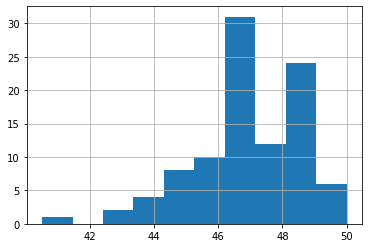

In [11]:
texas = polls[polls.state == 'Texas']
texas_biden = texas[texas.answer == 'Biden']
texas_biden.pct.hist();

On peut aussi utiliser les fonctions de `numpy` directement avec des `DataFrame` de `pandas`, par example on peut calculer la moyenne et l'écart type des pourcentages pour Biden en Texas :

_____
> __Exercice 2a)__  
> Écrire une fonction `etats_pct(etat)` qui retourne deux listes, une avec des pourcentages de votes estimés pour Biden pour cet état, et une pour Trump.  

_____

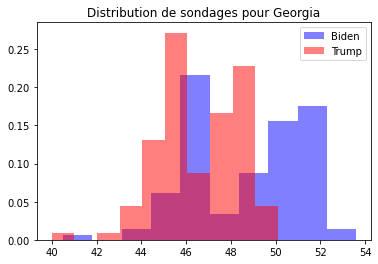

In [12]:
def etats_pct(etat):
    # BEGIN SOLUTION
    etat_df = polls[polls['state']==etat]
    biden = etat_df[etat_df['answer']=='Biden']
    trump = etat_df[etat_df['answer']=='Trump']

    return biden['pct'],trump['pct']
    # END SOLUTION

def plot_state(state):
    pct_biden,pct_trump = etats_pct(state)
    plt.hist(pct_biden,alpha=0.5,color='blue',density=True,label='Biden')
    plt.hist(pct_trump,alpha=0.5,color='red',density=True,label='Trump')
    plt.legend();
    plt.title(f'Distribution de sondages pour {state}')
plot_state('Georgia')

In [13]:
# TESTS AUTOMATIQUES

biden,trump = etats_pct("Iowa")
assert len(biden) == 86, "Le nombre de sondages pour Biden pour Iowa n'est pas correcte"
assert len(trump) == 86, "Le nombre de sondages pour Trump pour Iowa n'est pas correcte"
assert abs(np.mean(biden)-47.689)<1e-3, "Le moyenne des sondages n'est pas correcte"
assert abs(np.mean(trump)-48.219)<1e-3, "Le moyenne des sondages n'est pas correcte"
assert abs(np.std(biden)-2.2025)<1e-3, "L'écart type des sondages n'est pas correcte"
assert abs(np.std(trump)-2.0673)<1e-3, "L'écart type des sondages n'est pas correcte"

biden,trump = etats_pct("Minnesota")
assert len(biden) == 82, "Le nombre de sondages pour Biden pour Minnesota n'est pas correcte"
assert len(trump) == 82, "Le nombre de sondages pour Trump pour Minnesota n'est pas correcte"
assert abs(np.mean(biden)-52.9841)<1e-3, "Le moyenne des sondages n'est pas correcte"
assert abs(np.mean(trump)-42.4374)<1e-3, "Le moyenne des sondages n'est pas correcte"
assert abs(np.std(biden)-2.8979)<1e-3, "L'écart type des sondages n'est pas correcte"
assert abs(np.std(trump)-1.6555)<1e-3, "L'écart type des sondages n'est pas correcte"

_____
> __Exercice 2b)__  
> Écrire une fonction `chances_gagner(etat)` donne une estimation de les chances de gagner pour Biden dans un état. 
>
> _Indications:_
>
> - Obtenir les pourcentages estimé en utilisant `etats_pct`
> - Prend un échantillon avec répétition de taille 1000 de les deux listes de pourcentages (_suggestion: utiliser `np.random.choice`_)
> - Calculer la proportion des échantillons telles que la pourcentage de Biden est plus grand que la pourcentage de Trump  

_____

In [14]:
def chances_gagner(etat):
    # BEGIN SOLUTION
    pct_biden,pct_trump = etats_pct(etat)
    
    biden_choice = np.random.choice(a=pct_biden,size=1000)
    trump_choice = np.random.choice(a=pct_trump,size=1000)

    return np.mean(biden_choice > trump_choice)
    # END SOLUTION

chances_gagner('Georgia')

0.685

In [15]:
p = np.mean([chances_gagner('Georgia') for _ in range(50)])
assert (p>=0) and (p<=1), "Le resultat doit être une probabilité"
assert abs(p-0.6773) < 0.01, "Vérifier l'implémentation"
p = chances_gagner('New York')
assert (p>=0) and (p<=1), "Le resultat doit être une probabilité"
assert abs(p-1) < 0.01, "Vérifier l'implémentation"
p = chances_gagner('Alabama')
assert (p>=0) and (p<=1), "Le resultat doit être une probabilité"
assert abs(p) < 0.01, "Vérifier l'implémentation"

_____
> __Exercice 2c)__  
> Générer des listes `votes_biden` et `votes_trump` de taille 10000 qui contiennent des simulations d'élections
>
> _Indications:_
>
> - Utiliser `votes_df.state` pour une liste des états et `votes_df.votes` pour une liste des nombres des votes des collèges électoraux des états.
> - Pour chaque état: générer un échantillon de taille 10000 d'une variable aléatoire de Bernoulli avec probabilité de succès donnée par `chances_gagner(etat)`. Multiplier le resultat par le nombres des votes du collège électoral.
> - Ajouter les listes générées pour chaque état pour obtenir un échantillon pour les votes obtenu pour Biden
> - Le nombre de votes pour Trump sont donnée par 538 moins le nombre de votes pour Biden.
>
> _Remarque: On trouve une probabilité de presque 100% que Biden gagne. En réalité les sondages sont un peu biaisés en faveur des démocrates. C'est un effet connu._  

_____

In [16]:
votes_df = polls[['state','votes']].copy()
votes_df.drop_duplicates(inplace=True)
votes_df = votes_df.reset_index(drop=True)
votes_df.sort_values(by='state',inplace=True)

# BEGIN SOLUTION
votes_biden = []
for etat,vote in zip(votes_df.state,votes_df.votes):
    chances = chances_gagner(etat)
    votes_recu = (np.random.random(size=10000)<=chances)*vote
    votes_biden.append(votes_recu)
votes_biden = np.sum(np.stack(votes_biden),axis=0)
votes_trump = 538 - votes_biden
# END SOLUTION

print('Probabilité estimée que Biden aurait gagné:', np.mean(votes_biden>votes_trump))

Probabilité estimée que Biden aurait gagné: 0.9998


In [17]:
assert len(votes_biden)==10000, "Faire exactement 10000 simulations"
assert len(votes_trump)==10000, "Faire exactement 10000 simulations"
assert set(votes_biden+votes_trump) == {538}, "Vérifier que la totale de votes de chaque simulation est égale a 538"
assert np.abs(np.mean(votes_biden)-349.74) < 4, "La moyenne de votes pour Biden n'est pas correcte"
assert np.abs(np.std(votes_biden)-24.745) < 1.5, "L'écart type de votes pour Biden n'est pas correcte"
assert np.abs(np.mean(votes_trump)-188.19) < 4, "La moyenne de votes pour Trump n'est pas correcte"
assert np.abs(np.std(votes_trump)-24.745) < 1.5, "L'écart type de votes pour Trump n'est pas correcte"
assert np.mean(votes_biden>votes_trump)>0.98, "La probabilité de gagner pour Biden n'est pas correcte"

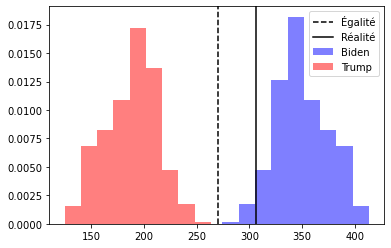

In [18]:
plt.hist(votes_biden,alpha=0.5,color='blue',density=True,label='Biden')
plt.hist(votes_trump,alpha=0.5,color='red',density=True,label='Trump')
plt.axvline(x=270,linestyle='dashed',c='k',label='Égalité')
plt.axvline(x=306,c='k',label='Réalité')
plt.legend();